In [206]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
import sqlalchemy
import pymysql
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [208]:
db_user = "cpidsadmin"
db_pass = "CpiDsAdmin"
db_name = "cpi_ds"
cloud_sql_connection_name = "eastern-archive-252417:asia-south1:cpi-ds"
db = sqlalchemy.create_engine(
    # Equivalent URL:
    # mysql+pymysql://<db_user>:<db_pass>@/<db_name>?unix_socket=/cloudsql/<cloud_sql_instance_name>
    sqlalchemy.engine.url.URL(
        drivername='mysql+pymysql',
        username=db_user,
        password=db_pass,
        database=db_name,
        query={
            'unix_socket': '/cloudsql/{}'.format(cloud_sql_connection_name)
        }
    ),
    # ... Specify additional properties here.
    # [START_EXCLUDE]

    # [START cloud_sql_mysql_sqlalchemy_limit]
    # Pool size is the maximum number of permanent connections to keep.
    pool_size=5,
    # Temporarily exceeds the set pool_size if no connections are available.
    max_overflow=2,
    # The total number of concurrent connections for your application will be
    # a total of pool_size and max_overflow.
    # [END cloud_sql_mysql_sqlalchemy_limit]

    # [START cloud_sql_mysql_sqlalchemy_backoff]
    # SQLAlchemy automatically uses delays between failed connection attempts,
    # but provides no arguments for configuration.
    # [END cloud_sql_mysql_sqlalchemy_backoff]

    # [START cloud_sql_mysql_sqlalchemy_timeout]
    # 'pool_timeout' is the maximum number of seconds to wait when retrieving a
    # new connection from the pool. After the specified amount of time, an
    # exception will be thrown.
    pool_timeout=30,  # 30 seconds
    # [END cloud_sql_mysql_sqlalchemy_timeout]

    # [START cloud_sql_mysql_sqlalchemy_lifetime]
    # 'pool_recycle' is the maximum number of seconds a connection can persist.
    # Connections that live longer than the specified amount of time will be
    # reestablished
    pool_recycle=1800,  # 30 minutes
    # [END cloud_sql_mysql_sqlalchemy_lifetime]

    # [END_EXCLUDE]
)
# [END cloud_sql_mysql_sqlalchemy_create]


with db.connect() as conn:
        data = conn.execute(
            "SELECT YEAR,MONTH,COMBINED FROM CPI_DS.CPI_HIST"
        ).fetchall()

data

AttributeError: module 'socket' has no attribute 'AF_UNIX'

In [141]:
df = pd.read_csv("data.csv",sep = '\t')
df.head()

,Year,Month,State,Description,Rural,Urban,Combined,Status
0,2013,January,Uttar Pradesh,Food and beverages,105.3,104.6,105.1,F
1,2013,February,Uttar Pradesh,Food and beverages,106.1,106.0,106.1,F
2,2013,March,Uttar Pradesh,Food and beverages,106.6,106.7,106.6,F
3,2013,April,Uttar Pradesh,Food and beverages,107.4,107.7,107.5,F
4,2013,May,Uttar Pradesh,Food and beverages,108.0,109.1,108.3,F


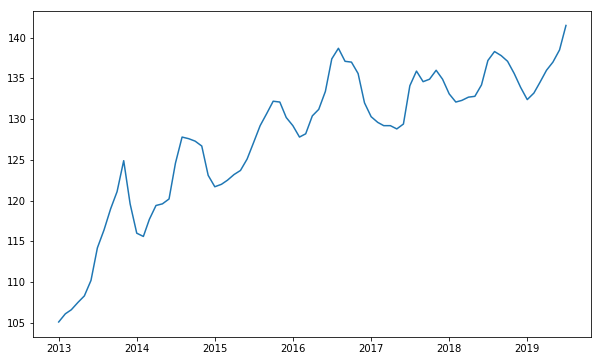

In [156]:
df1 = pd.DataFrame()
df['Date'] = df['Year'].astype('str') + '-' + df['Month'].astype('str') + '-1'
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df1 = df.set_index(['Date'])
df1 = df[['Date','Combined']]
df1 = df1.set_index(['Date'])
plt.plot(df1)

In [159]:
#Determine rolling statistics
rolmean = df1.rolling(window=2).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df1.rolling(window=2).std()
print(rolmean,rolstd)

            Combined
Date                
2013-01-01       NaN
2013-02-01    105.60
2013-03-01    106.35
2013-04-01    107.05
2013-05-01    107.90
2013-06-01    109.25
2013-07-01    112.20
2013-08-01    115.30
2013-09-01    117.70
2013-10-01    120.05
2013-11-01    123.00
2013-12-01    122.25
2014-01-01    117.80
2014-02-01    115.80
2014-03-01    116.65
2014-04-01    118.55
2014-05-01    119.50
2014-06-01    119.90
2014-07-01    122.40
2014-08-01    126.20
2014-09-01    127.70
2014-10-01    127.45
2014-11-01    127.00
2014-12-01    124.90
2015-01-01    122.40
2015-02-01    121.85
2015-03-01    122.25
2015-04-01    122.85
2015-05-01    123.45
2015-06-01    124.40
...              ...
2017-02-01    129.95
2017-03-01    129.40
2017-04-01    129.20
2017-05-01    129.00
2017-06-01    129.10
2017-07-01    131.75
2017-08-01    135.00
2017-09-01    135.25
2017-10-01    134.75
2017-11-01    135.45
2017-12-01    135.45
2018-01-01    134.00
2018-02-01    132.60
2018-03-01    132.20
2018-04-01   

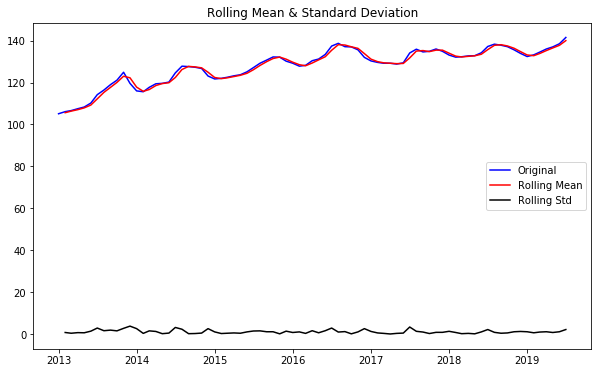

In [160]:
#Plot rolling statistics
orig = plt.plot(df1, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [166]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df1['Combined'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -1.341397
p-value                         0.610027
#Lags Used                     12.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


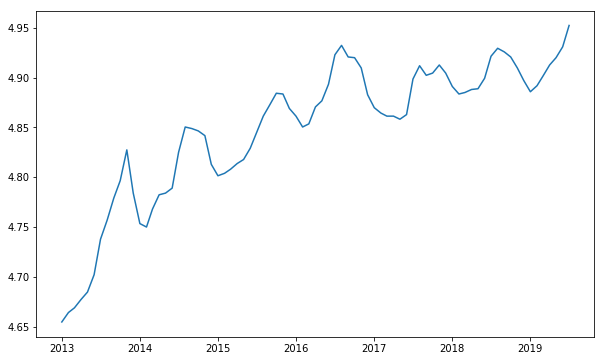

In [167]:
indexedDataset_logScale = np.log(df1)
plt.plot(indexedDataset_logScale)

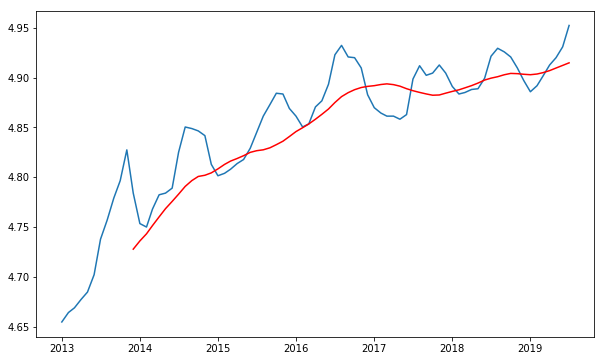

In [168]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [169]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Combined
Date,
2013-12-01,0.056198
2014-01-01,0.017412
2014-02-01,0.006812
2014-03-01,0.016560
2014-04-01,0.022151
2014-05-01,0.015554
2014-06-01,0.013320
2014-07-01,0.042008
2014-08-01,0.059580


In [209]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=2).mean()
    movingSTD = timeseries.rolling(window=2).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Combined'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

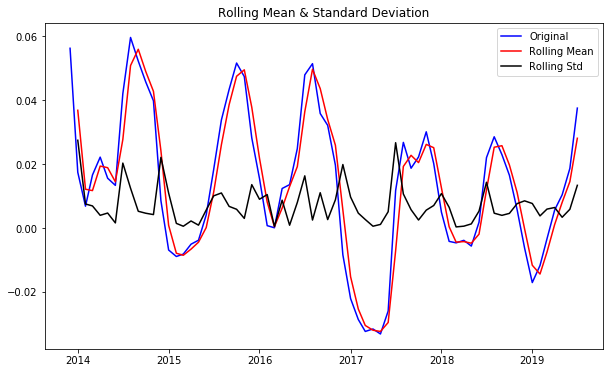

Results of Dickey Fuller Test:
Test Statistic                 -2.119079
p-value                         0.236912
#Lags Used                     11.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [210]:
test_stationarity(datasetLogScaleMinusMovingAverage)

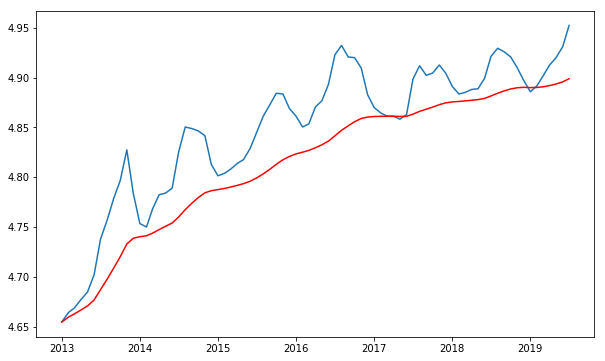

In [211]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

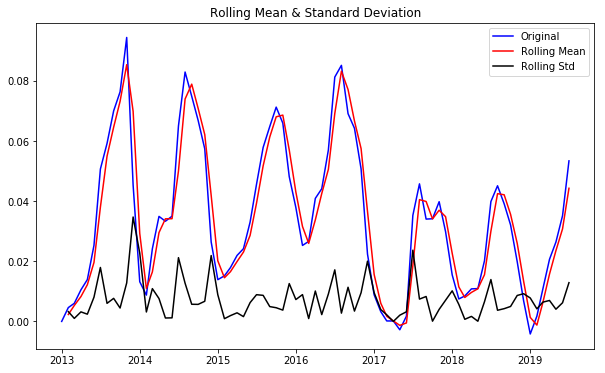

Results of Dickey Fuller Test:
Test Statistic                 -2.017171
p-value                         0.279095
#Lags Used                     12.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


In [212]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

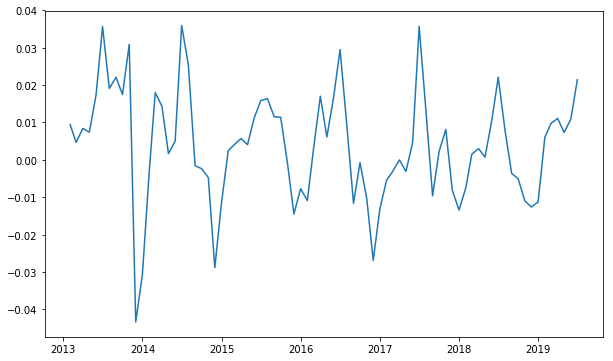

In [213]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

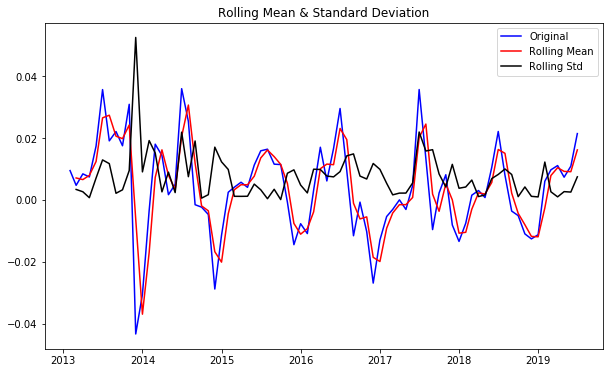

Results of Dickey Fuller Test:
Test Statistic                 -2.080100
p-value                         0.252592
#Lags Used                     11.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


In [214]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


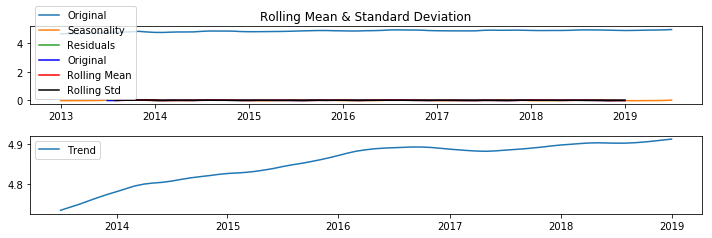

Results of Dickey Fuller Test:
Test Statistic                -5.693093e+00
p-value                        7.987435e-07
#Lags Used                     1.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


In [215]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

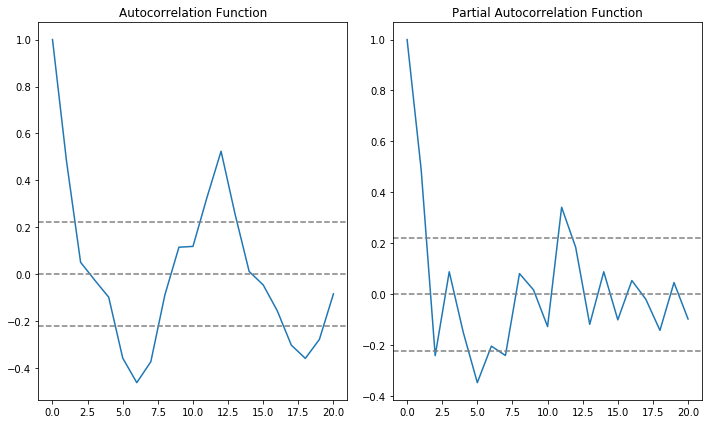

In [216]:
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


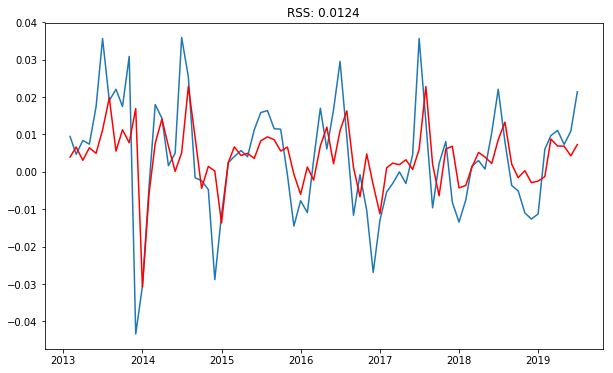

In [217]:
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Combined'])**2))
print('Plotting AR model')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


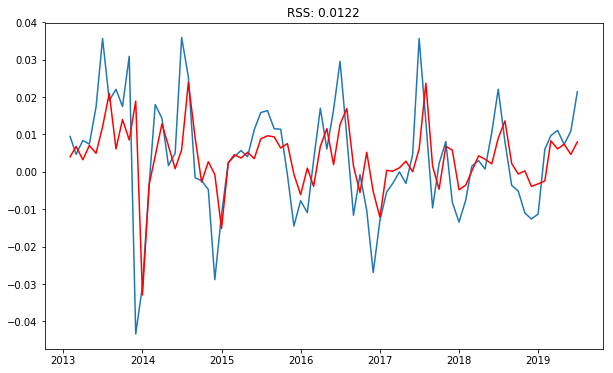

In [218]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Combined'])**2))
print('Plotting MA model')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


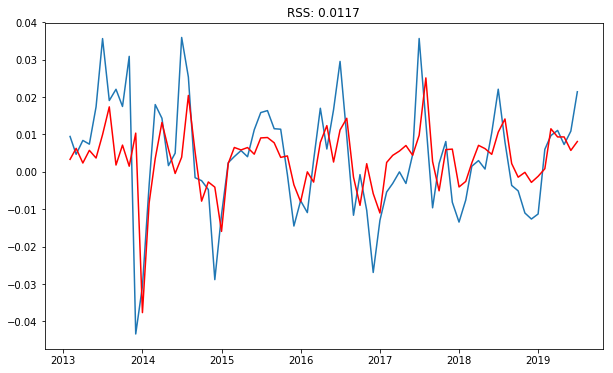

In [234]:
import dill as pickle
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Combined'])**2))
print('Plotting ARIMA model')

In [220]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2013-02-01    0.003349
2013-03-01    0.006285
2013-04-01    0.002372
2013-05-01    0.005756
2013-06-01    0.003703
dtype: float64


In [221]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Date
2013-02-01    0.003349
2013-03-01    0.009634
2013-04-01    0.012006
2013-05-01    0.017762
2013-06-01    0.021465
2013-07-01    0.031433
2013-08-01    0.048819
2013-09-01    0.050651
2013-10-01    0.057812
2013-11-01    0.059326
2013-12-01    0.069690
2014-01-01    0.032041
2014-02-01    0.023801
2014-03-01    0.027355
2014-04-01    0.040565
2014-05-01    0.046663
2014-06-01    0.046235
2014-07-01    0.050163
2014-08-01    0.070611
2014-09-01    0.075919
2014-10-01    0.068088
2014-11-01    0.065384
2014-12-01    0.061299
2015-01-01    0.045378
2015-02-01    0.047625
2015-03-01    0.054151
2015-04-01    0.060017
2015-05-01    0.066524
2015-06-01    0.071256
2015-07-01    0.080336
                ...   
2017-02-01    0.117219
2017-03-01    0.121633
2017-04-01    0.127199
2017-05-01    0.134248
2017-06-01    0.138702
2017-07-01    0.148491
2017-08-01    0.173624
2017-09-01    0.176386
2017-10-01    0.171316
2017-11-01    0.177263
2017-12-01    0.183351
2018-01-01    0.179314
2018-0

In [222]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Combined'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
2013-01-01    4.654912
2013-02-01    4.658262
2013-03-01    4.664546
2013-04-01    4.666919
2013-05-01    4.672674
dtype: float64

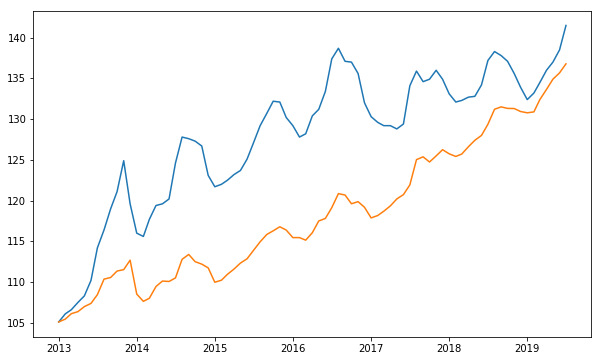

In [223]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df1)
plt.plot(predictions_ARIMA)

In [224]:
indexedDataset_logScale

,Combined
Date,
2013-01-01,4.654912
2013-02-01,4.664382
2013-03-01,4.669084
2013-04-01,4.677491
2013-05-01,4.684905
2013-06-01,4.702297
2013-07-01,4.737951
2013-08-01,4.757033
2013-09-01,4.779123


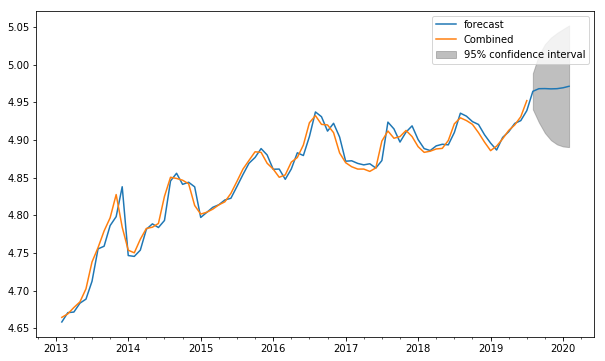

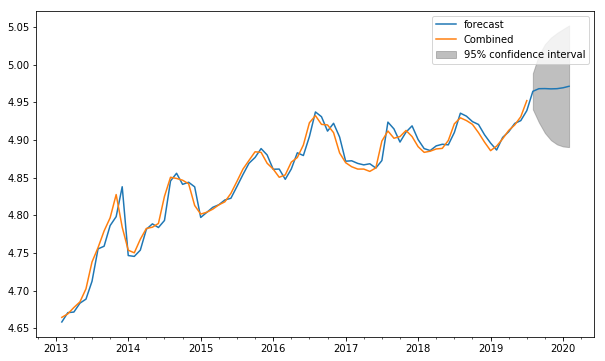

In [225]:
results_ARIMA.plot_predict(1,85)

In [239]:
filename = 'model_v1.pk'
with open(filename, 'wb') as file:
    pickle.dump(results_ARIMA, file)


In [240]:
with open(filename ,'rb') as f:
    loaded_model = pickle.load(f)

<Figure size 720x432 with 0 Axes>

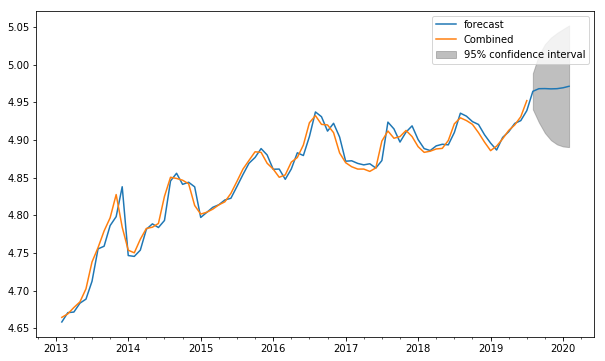

In [258]:
fig = plt.figure()
fig = loaded_model.plot_predict(1,85)
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

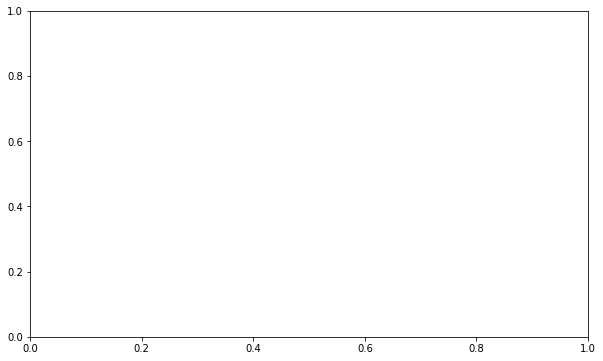